In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import xgboost as xgb
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

# Hiperparámetros XGBoost - Modelo 1
N_ESTIMATORS = 100
MAX_DEPTH = 6
LEARNING_RATE = 0.1
MIN_CHILD_WEIGHT = 5
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8

# Directorio de salida
OUTPUT_DIR = "../../data/xgboost-output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("MODELO XGBOOST - HOME CREDIT DEFAULT RISK")
print("="*80)
print(f"\nTipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)")
print(f"Algoritmo: Extreme Gradient Boosting (XGBoost)")
print(f"Directorio de salida: {OUTPUT_DIR}")


MODELO XGBOOST - HOME CREDIT DEFAULT RISK

Tipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)
Algoritmo: Extreme Gradient Boosting (XGBoost)
Directorio de salida: ../../data/xgboost-output


In [3]:
# =============================================================================
# 1. CARGA Y VERIFICACIÓN DE DATOS
# =============================================================================
print("\n[1/15] Cargando y verificando datos...")

df = pd.read_csv("/Users/jeronimo.deli/Desktop/other/Vs/MM/dataset_variables_completo.csv")

print(f"Dataset cargado: {df.shape}")
print(f"Usuarios: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Tasa de default: {df['TARGET'].mean()*100:.2f}%")



[1/15] Cargando y verificando datos...
Dataset cargado: (307511, 41)
Usuarios: 307,511
Variables: 41
Tasa de default: 8.07%


In [4]:
# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/15] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")



[2/15] Preparando datos...
Variables predictoras: 39
Variable objetivo: TARGET
Variables numericas: 34
Variables categoricas: 5


In [5]:
# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("\nImputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")



[3/15] Analizando valores faltantes...
Variables con valores faltantes: 10
TASA_INTERES_PROMEDIO    98.501192
RATIO_PAGO_MINIMO_TC     80.726218
EXT_SOURCE_1             56.381073
EXT_SOURCE_3             19.825307
PLAZO_PROMEDIO            5.485657
RATIO_PAGO_CUOTA          5.163718
EXT_SOURCE_2              0.214626
SCORE_PROMEDIO            0.055933
AMT_ANNUITY               0.003902
CNT_FAM_MEMBERS           0.000650
dtype: float64

Imputando valores faltantes...
Valores faltantes imputados


In [6]:
# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")



[4/15] Codificando variables categoricas...
5 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [7]:
# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")



[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)


In [8]:
# =============================================================================
# 6. NOTA SOBRE NORMALIZACIÓN
# =============================================================================
print("\n[6/15] Nota sobre normalizacion...")

# XGBoost NO requiere normalización ya que es un modelo basado en árboles
# Los árboles de decisión son invariantes a transformaciones monótonas de las features
# Usamos los datos sin escalar para mejor interpretabilidad

print("XGBoost no requiere normalizacion de datos")
print("Los arboles de decision son invariantes a escalas de las variables")
print("Se usaran los datos originales (sin escalar)")



[6/15] Nota sobre normalizacion...
XGBoost no requiere normalizacion de datos
Los arboles de decision son invariantes a escalas de las variables
Se usaran los datos originales (sin escalar)


# XGBoost 1 - Modelo con todas las variables (39 features)


In [9]:
# =============================================================================
# 7. ENTRENAMIENTO DEL MODELO XGBOOST 1
# =============================================================================
print("\n[7/15] Entrenando XGBoost...")

# Calcular scale_pos_weight para manejar desbalance de clases
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale_pos_weight (ratio negativo/positivo): {scale_pos_weight:.2f}")

model = xgb.XGBClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE,
    min_child_weight=MIN_CHILD_WEIGHT,
    subsample=SUBSAMPLE,
    colsample_bytree=COLSAMPLE_BYTREE,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='auc',
    use_label_encoder=False
)

model.fit(X_train, y_train)

print("\nModelo entrenado exitosamente")
print(f"Numero de arboles: {model.n_estimators}")
print(f"Profundidad maxima: {model.max_depth}")
print(f"Learning rate: {model.learning_rate}")
print(f"Min child weight: {model.min_child_weight}")
print(f"Subsample: {model.subsample}")
print(f"Colsample bytree: {model.colsample_bytree}")



[7/15] Entrenando XGBoost...
Scale_pos_weight (ratio negativo/positivo): 11.39

Modelo entrenado exitosamente
Numero de arboles: 100
Profundidad maxima: 6
Learning rate: 0.1
Min child weight: 5
Subsample: 0.8
Colsample bytree: 0.8


In [10]:
# =============================================================================
# 8. VALIDACIÓN CRUZADA
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores = cross_val_score(
    model, X_train, y_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores}")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



[8/15] Validacion Cruzada (5-fold en Train)...
ROC-AUC por fold: [0.75836505 0.74776742 0.75609189 0.75829901 0.76023266]
Media: 0.7562 (+/- 0.0044)


In [11]:
# =============================================================================
# 9. PREDICCIONES
# =============================================================================
print("\n[9/15] Generando predicciones...")

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Predicciones generadas")



[9/15] Generando predicciones...
Predicciones generadas


In [12]:
# =============================================================================
# 10. EVALUACIÓN EN TRAIN
# =============================================================================
print("\n[10/15] Evaluando modelo en TRAIN SET...")
print("="*80)

train_auc = roc_auc_score(y_train, y_train_proba)
train_ap = average_precision_score(y_train, y_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train_auc:.4f}")
print(f"Average Precision: {train_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_train[1,1]:,} - Predijo 'Default' y si hizo default")



[10/15] Evaluando modelo en TRAIN SET...

Metricas Globales:
ROC-AUC Score: 0.8088
Average Precision: 0.3054

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.97      0.73      0.83    226148
 Default (1)       0.19      0.74      0.30     19860

    accuracy                           0.73    246008
   macro avg       0.58      0.73      0.57    246008
weighted avg       0.91      0.73      0.79    246008


Confusion Matrix:
[[164094  62054]
 [  5260  14600]]

Interpretacion:
  Verdaderos Negativos (TN): 164,094 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 62,054 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 5,260 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 14,600 - Predijo 'Default' y si hizo default


In [13]:
# =============================================================================
# 11. EVALUACIÓN EN TEST
# =============================================================================
print("\n[11/15] Evaluando modelo en TEST SET (metricas definitivas)...")
print("="*80)

test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_test[1,1]:,} - Predijo 'Default' y si hizo default")



[11/15] Evaluando modelo en TEST SET (metricas definitivas)...

Metricas Globales:
ROC-AUC Score: 0.7616
Average Precision: 0.2502

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.96      0.72      0.82     56538
 Default (1)       0.17      0.67      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503


Confusion Matrix:
[[40777 15761]
 [ 1641  3324]]

Interpretacion:
  Verdaderos Negativos (TN): 40,777 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 15,761 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 1,641 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 3,324 - Predijo 'Default' y si hizo default


In [14]:
# =============================================================================
# 12. COMPARACIÓN TRAIN VS TEST
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train_auc:<12.4f} {test_auc:<12.4f} {abs(train_auc-test_auc):<12.4f}")
print(f"{'Average Precision':<25} {train_ap:<12.4f} {test_ap:<12.4f} {abs(train_ap-test_ap):<12.4f}")

diff_auc = abs(train_auc - test_auc)
if diff_auc < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")



[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...

Metrica                   Train        Test         Diferencia  
-----------------------------------------------------------------
ROC-AUC                   0.8088       0.7616       0.0472      
Average Precision         0.3054       0.2502       0.0552      

Buena generalizacion (diferencia < 5%)


In [15]:
# =============================================================================
# 13. IMPORTANCIA DE VARIABLES
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

# XGBoost usa importancia basada en gain (ganancia promedio en splits)
# También puede usar weight (número de veces que se usa) o cover (muestras cubiertas)

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nTop 20 variables mas importantes para predecir default:\n")
print(feature_importance.head(20).to_string(index=False))

print("\nInterpretacion de importancia (Gain):")
print("  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Default)")
print("  - Gain mide la mejora promedio en la función objetivo al usar la variable")
print("  - Valores mas altos = mayor capacidad para mejorar las predicciones")
print("  - Basado en la ganancia promedio en todos los árboles del ensemble")



[13/15] Calculando importancia de variables...

Top 20 variables mas importantes para predecir default:

               Variable  Importancia
         SCORE_PROMEDIO     0.192897
           EXT_SOURCE_2     0.050609
    NAME_EDUCATION_TYPE     0.044886
            CODE_GENDER     0.044871
           FLAG_OWN_CAR     0.036816
           EXT_SOURCE_3     0.031341
           EXT_SOURCE_1     0.030870
       RATIO_PAGO_CUOTA     0.029666
              EDAD_ANOS     0.029072
   RATIO_PAGO_MINIMO_TC     0.025168
         PLAZO_PROMEDIO     0.024237
 TOTAL_CREDITO_OTORGADO     0.023825
     NAME_FAMILY_STATUS     0.022774
             DAYS_BIRTH     0.022256
       CREDITOS_ACTIVOS     0.022148
             AMT_CREDIT     0.021905
      CREDITOS_CERRADOS     0.021111
            AMT_ANNUITY     0.019631
TOTAL_CREDITO_HISTORICO     0.018319
      ES_PRIMER_CREDITO     0.018016

Interpretacion de importancia (Gain):
  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Default)
  - Gai


[14/15] Generando visualizaciones...
Graficas guardadas: ../../data/xgboost-output/xgboost1_curves.png


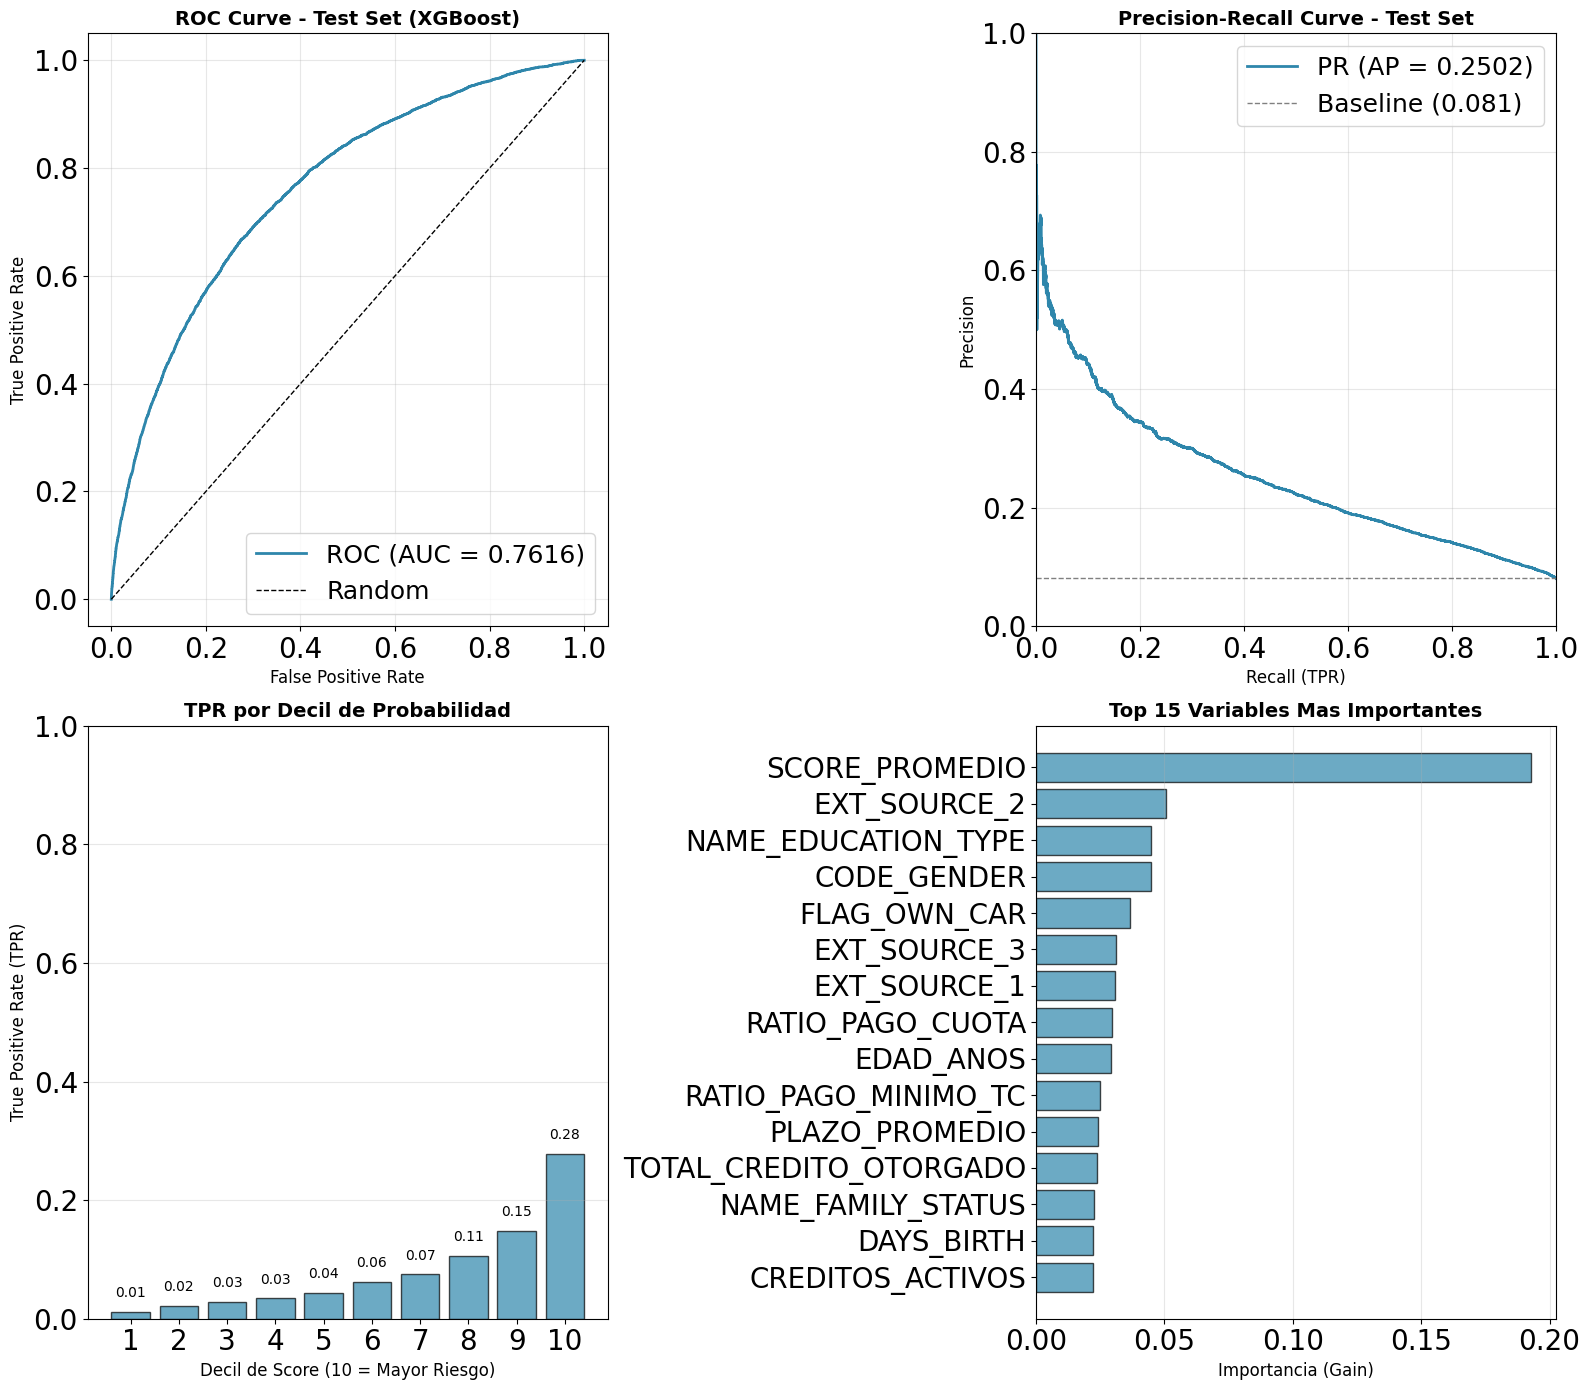


Tabla de TPR por Decil:
 decil  positivos  total      tpr
    10       1710   6151 0.278004
     9        914   6150 0.148618
     8        649   6150 0.105528
     7        459   6150 0.074634
     6        378   6150 0.061463
     5        267   6151 0.043408
     4        210   6150 0.034146
     3        174   6150 0.028293
     2        131   6150 0.021301
     1         73   6151 0.011868


In [16]:
# =============================================================================
# 14. VISUALIZACIONES
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba
})
test_results['decil'] = pd.qcut(test_results['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats = test_results.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats = decil_stats.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0, 0].plot(fpr, tpr, linewidth=2, color='#2E86AB', label=f'ROC (AUC = {test_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve - Test Set (XGBoost)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
sort_idx = np.argsort(recall)
recall_sorted = recall[sort_idx]
precision_sorted = precision[sort_idx]

axes[0, 1].plot(recall_sorted, precision_sorted, linewidth=2, color='#2E86AB', label=f'PR (AP = {test_ap:.4f})')
axes[0, 1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall (TPR)', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TPR por Decil
axes[1, 0].bar(decil_stats['decil'], decil_stats['tpr'], color='#2E86AB', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[1, 0].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

for i, row in decil_stats.iterrows():
    axes[1, 0].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

# Feature Importance (Top 15)
top_features = feature_importance.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['Importancia'].values, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Variable'].values)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=12)
axes[1, 1].set_title('Top 15 Variables Mas Importantes', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/xgboost1_curves.png', dpi=300, bbox_inches='tight')
print(f"Graficas guardadas: {OUTPUT_DIR}/xgboost1_curves.png")

plt.show()

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats.to_string(index=False))


In [17]:
# =============================================================================
# 15. GUARDAR MODELO Y RESULTADOS
# =============================================================================
print("\n[15/15] Guardando modelo y resultados...")

with open(f'{OUTPUT_DIR}/xgboost1_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open(f'{OUTPUT_DIR}/label_encoders_xgb.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

feature_importance.to_csv(f'{OUTPUT_DIR}/feature_importance_xgb1.csv', index=False)

test_predictions = pd.DataFrame({
    'SK_ID_CURR': df.iloc[X_test.index]['SK_ID_CURR'].values,
    'TARGET_Real': y_test.values,
    'TARGET_Predicho': y_test_pred,
    'Probabilidad_Default': y_test_proba
})
test_predictions.to_csv(f'{OUTPUT_DIR}/test_predictions_xgb1.csv', index=False)

print(f"Archivos guardados en: {OUTPUT_DIR}/")
print("  - xgboost1_model.pkl")
print("  - label_encoders_xgb.pkl")
print("  - feature_importance_xgb1.csv")
print("  - test_predictions_xgb1.csv")
print("  - xgboost1_curves.png")

# =============================================================================
# RESUMEN FINAL - XGBOOST 1
# =============================================================================
print("\n" + "="*80)
print("ANALISIS COMPLETADO - XGBOOST 1")
print("="*80)
print(f"\nTipo de problema: CLASIFICACIÓN BINARIA")
print(f"  - Objetivo: Predecir si un cliente hará default (1) o pagará (0)")
print(f"  - Algoritmo: XGBoost (Extreme Gradient Boosting)")
print(f"\nResultados Finales (TEST SET):")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  Average Precision: {test_ap:.4f}")
print(f"  Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"\nConfiguracion del modelo:")
print(f"  N_ESTIMATORS: {N_ESTIMATORS}")
print(f"  MAX_DEPTH: {MAX_DEPTH}")
print(f"  LEARNING_RATE: {LEARNING_RATE}")
print(f"  MIN_CHILD_WEIGHT: {MIN_CHILD_WEIGHT}")
print(f"  SUBSAMPLE: {SUBSAMPLE}")
print(f"  COLSAMPLE_BYTREE: {COLSAMPLE_BYTREE}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}/")
print("="*80)



[15/15] Guardando modelo y resultados...
Archivos guardados en: ../../data/xgboost-output/
  - xgboost1_model.pkl
  - label_encoders_xgb.pkl
  - feature_importance_xgb1.csv
  - test_predictions_xgb1.csv
  - xgboost1_curves.png

ANALISIS COMPLETADO - XGBOOST 1

Tipo de problema: CLASIFICACIÓN BINARIA
  - Objetivo: Predecir si un cliente hará default (1) o pagará (0)
  - Algoritmo: XGBoost (Extreme Gradient Boosting)

Resultados Finales (TEST SET):
  ROC-AUC: 0.7616
  Average Precision: 0.2502
  Accuracy: 0.7171

Configuracion del modelo:
  N_ESTIMATORS: 100
  MAX_DEPTH: 6
  LEARNING_RATE: 0.1
  MIN_CHILD_WEIGHT: 5
  SUBSAMPLE: 0.8
  COLSAMPLE_BYTREE: 0.8

Archivos guardados en: ../../data/xgboost-output/


# XGBoost 2 - Modelo con variables reducidas (24 features)


In [19]:
# =============================================================================
# XGBOOST 2 - DROP DE VARIABLES REDUNDANTES/DERIVADAS
# =============================================================================
# Recargar datos para modelo 2
df2 = pd.read_csv("/Users/jeronimo.deli/Desktop/other/Vs/MM/dataset_variables_completo.csv")

# Drop de variables redundantes/derivadas (mismas que en Random Forest)
df2 = df2.drop(columns=[
    # Edad
    'DAYS_BIRTH',
    
    # Montos base
    'AMT_CREDIT',
    'AMT_INCOME_TOTAL',
    'AMT_ANNUITY',
    
    # Scores individuales
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    
    # Familia
    'CNT_FAM_MEMBERS',
    
    # Activos
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    
    # Consultas buró total
    'TOTAL_CONSULTAS_BURO',
    
    # Componentes de ratios
    'MESES_CON_MORA',
    
    # Variables binarias derivadas
    'TIENE_IMPAGOS',
    'ES_PRIMER_CREDITO',
    
    # Créditos buró
    'CANTIDAD_CREDITOS_BURO'
])

print("="*80)
print("XGBOOST 2 - MODELO CON VARIABLES REDUCIDAS")
print("="*80)
print(f"\nDataset despues de drop: {df2.shape}")
print(f"Variables eliminadas: 15")
print(f"Variables restantes: {len(df2.columns)}")


XGBOOST 2 - MODELO CON VARIABLES REDUCIDAS

Dataset despues de drop: (307511, 26)
Variables eliminadas: 15
Variables restantes: 26


In [20]:
# =============================================================================
# PREPARACIÓN DE DATOS - MODELO 2
# =============================================================================
print("\n[2/15] Preparando datos para modelo 2...")

X2 = df2.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y2 = df2['TARGET']

print(f"Variables predictoras: {X2.shape[1]}")
print(f"Variable objetivo: {y2.name}")

numeric_vars2 = X2.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars2 = X2.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars2)}")
print(f"Variables categoricas: {len(categorical_vars2)}")
print(f"\nVariables en el modelo:")
for i, col in enumerate(X2.columns, 1):
    print(f"  {i}. {col}")



[2/15] Preparando datos para modelo 2...
Variables predictoras: 24
Variable objetivo: TARGET
Variables numericas: 21
Variables categoricas: 3

Variables en el modelo:
  1. EDAD_ANOS
  2. SCORE_PROMEDIO
  3. CREDIT_INCOME_RATIO
  4. NAME_FAMILY_STATUS
  5. CNT_CHILDREN
  6. CODE_GENDER
  7. NAME_EDUCATION_TYPE
  8. INGRESO_PER_CAPITA
  9. NUM_ACTIVOS
  10. TOTAL_CREDITO_DISPONIBLE
  11. TOTAL_CREDITO_OTORGADO
  12. TOTAL_DEUDA_ACTUAL
  13. MAX_DIAS_MORA
  14. CREDITOS_ACTIVOS
  15. CREDITOS_CERRADOS
  16. PCT_MESES_MORA
  17. CREDITOS_CON_IMPAGO
  18. NUM_PRESTAMOS_PREVIOS
  19. TASA_INTERES_PROMEDIO
  20. PLAZO_PROMEDIO
  21. MONTO_PROMEDIO_PREVIO
  22. TOTAL_CREDITO_HISTORICO
  23. RATIO_PAGO_CUOTA
  24. RATIO_PAGO_MINIMO_TC


In [21]:
# =============================================================================
# MANEJO DE VALORES FALTANTES - MODELO 2
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct2 = (X2.isnull().sum() / len(X2) * 100).sort_values(ascending=False)
missing_vars2 = missing_pct2[missing_pct2 > 0]

if len(missing_vars2) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars2)}")
    print(missing_vars2.head(10))
    
    print("\nImputando valores faltantes...")
    for col in numeric_vars2:
        if X2[col].isnull().sum() > 0:
            X2[col].fillna(X2[col].median(), inplace=True)
    
    for col in categorical_vars2:
        if X2[col].isnull().sum() > 0:
            X2[col].fillna(X2[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")



[3/15] Analizando valores faltantes...
Variables con valores faltantes: 5
TASA_INTERES_PROMEDIO    98.501192
RATIO_PAGO_MINIMO_TC     80.726218
PLAZO_PROMEDIO            5.485657
RATIO_PAGO_CUOTA          5.163718
SCORE_PROMEDIO            0.055933
dtype: float64

Imputando valores faltantes...
Valores faltantes imputados


In [22]:
# =============================================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS - MODELO 2
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders2 = {}

if len(categorical_vars2) > 0:
    for col in categorical_vars2:
        le = LabelEncoder()
        X2[col] = le.fit_transform(X2[col].astype(str))
        label_encoders2[col] = le
    
    print(f"{len(categorical_vars2)} variables codificadas")
    print(f"Categorias: {categorical_vars2}")
else:
    print("No hay variables categoricas para codificar")



[4/15] Codificando variables categoricas...
3 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']


In [23]:
# =============================================================================
# DIVISIÓN TRAIN/TEST - MODELO 2
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y2
)

print(f"Train set: {X2_train.shape[0]:,} usuarios ({X2_train.shape[0]/len(X2)*100:.1f}%)")
print(f"Test set:  {X2_test.shape[0]:,} usuarios ({X2_test.shape[0]/len(X2)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y2_train==0).sum():,} ({(y2_train==0).sum()/len(y2_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y2_train==1).sum():,} ({(y2_train==1).sum()/len(y2_train)*100:.2f}%)")



[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)


In [24]:
# =============================================================================
# ENTRENAMIENTO DEL MODELO XGBOOST 2
# =============================================================================
print("\n[7/15] Entrenando XGBoost 2 (variables reducidas)...")

# Calcular scale_pos_weight
scale_pos_weight2 = (y2_train == 0).sum() / (y2_train == 1).sum()

model2 = xgb.XGBClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE,
    min_child_weight=MIN_CHILD_WEIGHT,
    subsample=SUBSAMPLE,
    colsample_bytree=COLSAMPLE_BYTREE,
    scale_pos_weight=scale_pos_weight2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='auc',
    use_label_encoder=False
)

model2.fit(X2_train, y2_train)

print("\nModelo 2 entrenado exitosamente")
print(f"Numero de arboles: {model2.n_estimators}")
print(f"Profundidad maxima: {model2.max_depth}")
print(f"Learning rate: {model2.learning_rate}")
print(f"Variables usadas: {X2.shape[1]}")



[7/15] Entrenando XGBoost 2 (variables reducidas)...

Modelo 2 entrenado exitosamente
Numero de arboles: 100
Profundidad maxima: 6
Learning rate: 0.1
Variables usadas: 24


In [25]:
# =============================================================================
# VALIDACIÓN CRUZADA - MODELO 2
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores2 = cross_val_score(
    model2, X2_train, y2_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores2}")
print(f"Media: {cv_scores2.mean():.4f} (+/- {cv_scores2.std():.4f})")



[8/15] Validacion Cruzada (5-fold en Train)...
ROC-AUC por fold: [0.75115725 0.74040173 0.7474086  0.75013455 0.75579741]
Media: 0.7490 (+/- 0.0051)


In [26]:
# =============================================================================
# PREDICCIONES - MODELO 2
# =============================================================================
print("\n[9/15] Generando predicciones...")

y2_train_pred = model2.predict(X2_train)
y2_train_proba = model2.predict_proba(X2_train)[:, 1]

y2_test_pred = model2.predict(X2_test)
y2_test_proba = model2.predict_proba(X2_test)[:, 1]

print("Predicciones generadas")



[9/15] Generando predicciones...
Predicciones generadas


In [27]:
# =============================================================================
# EVALUACIÓN EN TRAIN - MODELO 2
# =============================================================================
print("\n[10/15] Evaluando modelo 2 en TRAIN SET...")
print("="*80)

train2_auc = roc_auc_score(y2_train, y2_train_proba)
train2_ap = average_precision_score(y2_train, y2_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train2_auc:.4f}")
print(f"Average Precision: {train2_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y2_train, y2_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm2_train = confusion_matrix(y2_train, y2_train_pred)
print(cm2_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm2_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm2_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm2_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm2_train[1,1]:,} - Predijo 'Default' y si hizo default")



[10/15] Evaluando modelo 2 en TRAIN SET...

Metricas Globales:
ROC-AUC Score: 0.7950
Average Precision: 0.2853

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.97      0.71      0.82    226148
 Default (1)       0.18      0.73      0.29     19860

    accuracy                           0.71    246008
   macro avg       0.57      0.72      0.56    246008
weighted avg       0.90      0.71      0.78    246008


Confusion Matrix:
[[161000  65148]
 [  5397  14463]]

Interpretacion:
  Verdaderos Negativos (TN): 161,000 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 65,148 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 5,397 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 14,463 - Predijo 'Default' y si hizo default


In [28]:
# =============================================================================
# EVALUACIÓN EN TEST - MODELO 2
# =============================================================================
print("\n[11/15] Evaluando modelo 2 en TEST SET (metricas definitivas)...")
print("="*80)

test2_auc = roc_auc_score(y2_test, y2_test_proba)
test2_ap = average_precision_score(y2_test, y2_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test2_auc:.4f}")
print(f"Average Precision: {test2_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y2_test, y2_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm2_test = confusion_matrix(y2_test, y2_test_pred)
print(cm2_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm2_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm2_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm2_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm2_test[1,1]:,} - Predijo 'Default' y si hizo default")



[11/15] Evaluando modelo 2 en TEST SET (metricas definitivas)...

Metricas Globales:
ROC-AUC Score: 0.7531
Average Precision: 0.2339

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.96      0.71      0.82     56538
 Default (1)       0.17      0.67      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503


Confusion Matrix:
[[40018 16520]
 [ 1645  3320]]

Interpretacion:
  Verdaderos Negativos (TN): 40,018 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 16,520 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 1,645 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 3,320 - Predijo 'Default' y si hizo default


In [29]:
# =============================================================================
# COMPARACIÓN TRAIN VS TEST - MODELO 2
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train2_auc:<12.4f} {test2_auc:<12.4f} {abs(train2_auc-test2_auc):<12.4f}")
print(f"{'Average Precision':<25} {train2_ap:<12.4f} {test2_ap:<12.4f} {abs(train2_ap-test2_ap):<12.4f}")

diff_auc2 = abs(train2_auc - test2_auc)
if diff_auc2 < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc2 < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc2 < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")



[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...

Metrica                   Train        Test         Diferencia  
-----------------------------------------------------------------
ROC-AUC                   0.7950       0.7531       0.0419      
Average Precision         0.2853       0.2339       0.0513      

Buena generalizacion (diferencia < 5%)


In [30]:
# =============================================================================
# IMPORTANCIA DE VARIABLES - MODELO 2
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

feature_importance2 = pd.DataFrame({
    'Variable': X2.columns,
    'Importancia': model2.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nTop 20 variables mas importantes para predecir default:\n")
print(feature_importance2.head(20).to_string(index=False))

print("\nInterpretacion de importancia (Gain):")
print("  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Default)")
print("  - Gain mide la mejora promedio en la función objetivo al usar la variable")
print("  - Valores mas altos = mayor capacidad para mejorar las predicciones")
print("  - Basado en la ganancia promedio en todos los árboles del ensemble")



[13/15] Calculando importancia de variables...

Top 20 variables mas importantes para predecir default:

                Variable  Importancia
          SCORE_PROMEDIO     0.230672
     NAME_EDUCATION_TYPE     0.099214
             CODE_GENDER     0.068477
        RATIO_PAGO_CUOTA     0.044946
        CREDITOS_ACTIVOS     0.044112
               EDAD_ANOS     0.042175
       CREDITOS_CERRADOS     0.038124
    RATIO_PAGO_MINIMO_TC     0.035413
          PLAZO_PROMEDIO     0.033807
      NAME_FAMILY_STATUS     0.032613
  TOTAL_CREDITO_OTORGADO     0.032204
      TOTAL_DEUDA_ACTUAL     0.030215
          PCT_MESES_MORA     0.026872
TOTAL_CREDITO_DISPONIBLE     0.024996
     CREDIT_INCOME_RATIO     0.024659
     CREDITOS_CON_IMPAGO     0.024416
             NUM_ACTIVOS     0.024161
 TOTAL_CREDITO_HISTORICO     0.023869
   MONTO_PROMEDIO_PREVIO     0.022570
      INGRESO_PER_CAPITA     0.021467

Interpretacion de importancia (Gain):
  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) 


[14/15] Generando visualizaciones...
Graficas guardadas: ../../data/xgboost-output/xgboost2_curves.png


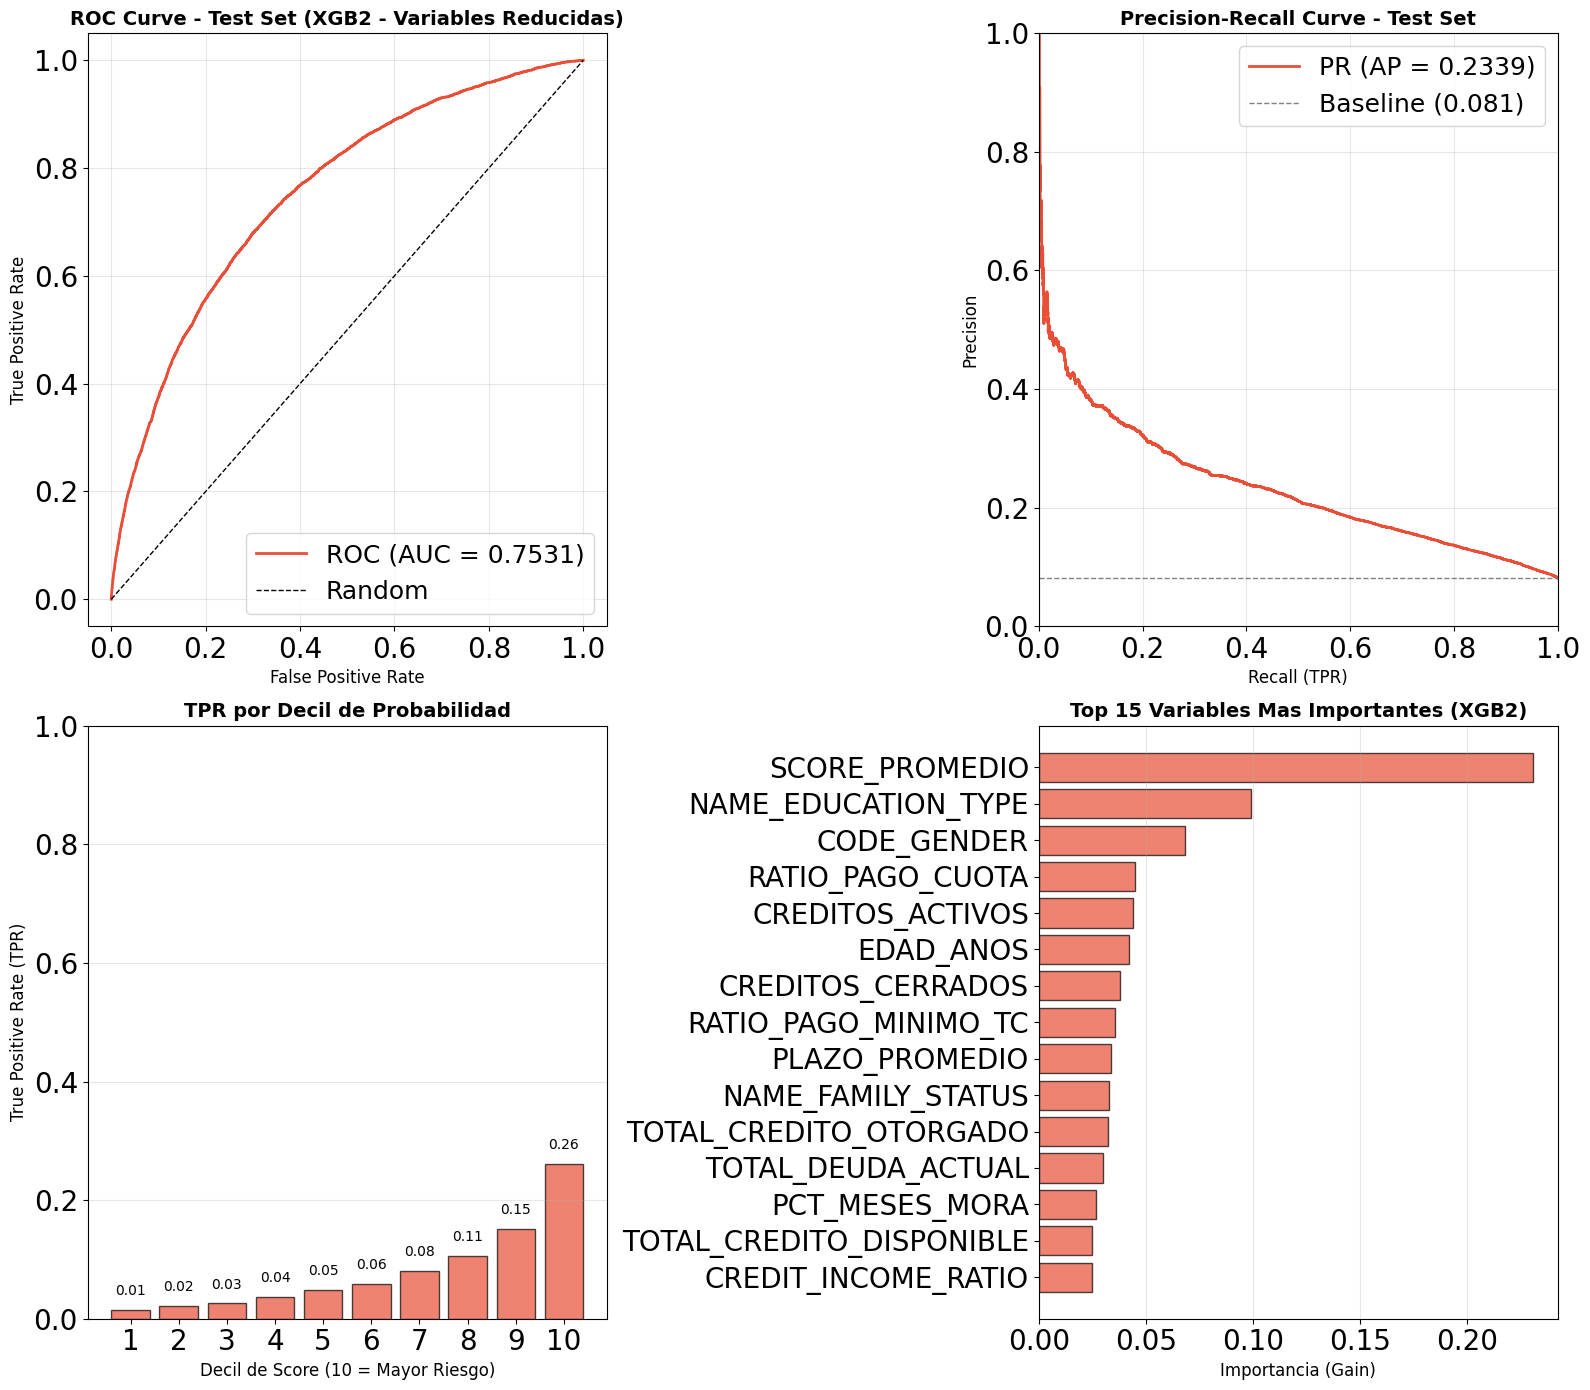


Tabla de TPR por Decil:
 decil  positivos  total      tpr
    10       1609   6151 0.261583
     9        933   6150 0.151707
     8        655   6150 0.106504
     7        499   6150 0.081138
     6        361   6150 0.058699
     5        297   6151 0.048285
     4        228   6150 0.037073
     3        159   6150 0.025854
     2        137   6150 0.022276
     1         87   6151 0.014144


In [31]:
# =============================================================================
# VISUALIZACIONES - MODELO 2
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results2 = pd.DataFrame({
    'y_true': y2_test,
    'y_proba': y2_test_proba
})
test_results2['decil'] = pd.qcut(test_results2['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats2 = test_results2.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats2.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats2 = decil_stats2.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ROC Curve
fpr2, tpr2, _ = roc_curve(y2_test, y2_test_proba)
axes[0, 0].plot(fpr2, tpr2, linewidth=2, color='#E94F37', label=f'ROC (AUC = {test2_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve - Test Set (XGB2 - Variables Reducidas)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision2, recall2, _ = precision_recall_curve(y2_test, y2_test_proba)
sort_idx2 = np.argsort(recall2)
recall_sorted2 = recall2[sort_idx2]
precision_sorted2 = precision2[sort_idx2]

axes[0, 1].plot(recall_sorted2, precision_sorted2, linewidth=2, color='#E94F37', label=f'PR (AP = {test2_ap:.4f})')
axes[0, 1].axhline(y=y2_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y2_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall (TPR)', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TPR por Decil
axes[1, 0].bar(decil_stats2['decil'], decil_stats2['tpr'], color='#E94F37', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[1, 0].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

for i, row in decil_stats2.iterrows():
    axes[1, 0].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

# Feature Importance (Top 15)
top_features2 = feature_importance2.head(15)
axes[1, 1].barh(range(len(top_features2)), top_features2['Importancia'].values, color='#E94F37', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features2)))
axes[1, 1].set_yticklabels(top_features2['Variable'].values)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=12)
axes[1, 1].set_title('Top 15 Variables Mas Importantes (XGB2)', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/xgboost2_curves.png', dpi=300, bbox_inches='tight')
print(f"Graficas guardadas: {OUTPUT_DIR}/xgboost2_curves.png")

plt.show()

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats2.to_string(index=False))


In [32]:
# =============================================================================
# GUARDAR MODELO Y RESULTADOS - MODELO 2
# =============================================================================
print("\n[15/15] Guardando modelo 2 y resultados...")

with open(f'{OUTPUT_DIR}/xgboost2_model.pkl', 'wb') as f:
    pickle.dump(model2, f)

with open(f'{OUTPUT_DIR}/label_encoders_xgb2.pkl', 'wb') as f:
    pickle.dump(label_encoders2, f)

feature_importance2.to_csv(f'{OUTPUT_DIR}/feature_importance_xgb2.csv', index=False)

test_predictions2 = pd.DataFrame({
    'SK_ID_CURR': df2.iloc[X2_test.index]['SK_ID_CURR'].values,
    'TARGET_Real': y2_test.values,
    'TARGET_Predicho': y2_test_pred,
    'Probabilidad_Default': y2_test_proba
})
test_predictions2.to_csv(f'{OUTPUT_DIR}/test_predictions_xgb2.csv', index=False)

print(f"Archivos guardados en: {OUTPUT_DIR}/")
print("  - xgboost2_model.pkl")
print("  - label_encoders_xgb2.pkl")
print("  - feature_importance_xgb2.csv")
print("  - test_predictions_xgb2.csv")
print("  - xgboost2_curves.png")



[15/15] Guardando modelo 2 y resultados...
Archivos guardados en: ../../data/xgboost-output/
  - xgboost2_model.pkl
  - label_encoders_xgb2.pkl
  - feature_importance_xgb2.csv
  - test_predictions_xgb2.csv
  - xgboost2_curves.png


In [33]:
# =============================================================================
# COMPARACIÓN MODELO 1 VS MODELO 2
# =============================================================================
print("\n" + "="*80)
print("COMPARACIÓN: XGBOOST 1 (39 vars) VS XGBOOST 2 (24 vars)")
print("="*80)

print(f"\n{'Metrica':<25} {'XGB1 (39 vars)':<15} {'XGB2 (24 vars)':<15} {'Diferencia':<12}")
print("-" * 70)
print(f"{'ROC-AUC (Test)':<25} {test_auc:<15.4f} {test2_auc:<15.4f} {test2_auc - test_auc:<12.4f}")
print(f"{'Average Precision (Test)':<25} {test_ap:<15.4f} {test2_ap:<15.4f} {test2_ap - test_ap:<12.4f}")
print(f"{'ROC-AUC (Train)':<25} {train_auc:<15.4f} {train2_auc:<15.4f} {train2_auc - train_auc:<12.4f}")
print(f"{'Overfitting (Train-Test)':<25} {train_auc - test_auc:<15.4f} {train2_auc - test2_auc:<15.4f}")

print(f"\nNumero de variables:")
print(f"  Modelo 1: {X.shape[1]} variables")
print(f"  Modelo 2: {X2.shape[1]} variables")
print(f"  Reduccion: {X.shape[1] - X2.shape[1]} variables eliminadas ({(X.shape[1] - X2.shape[1])/X.shape[1]*100:.1f}%)")

# Conclusión
if test2_auc >= test_auc:
    print(f"\n✓ Modelo 2 tiene MEJOR o IGUAL rendimiento con menos variables")
    print(f"  Esto sugiere que las variables eliminadas eran redundantes")
else:
    print(f"\n✗ Modelo 2 tiene PEOR rendimiento")
    print(f"  Diferencia de AUC: {test_auc - test2_auc:.4f}")

print("\n" + "="*80)
print("ANALISIS COMPLETADO - XGBOOST (AMBOS MODELOS)")
print("="*80)
print(f"\nConfiguracion de hiperparametros (ambos modelos):")
print(f"  N_ESTIMATORS: {N_ESTIMATORS}")
print(f"  MAX_DEPTH: {MAX_DEPTH}")
print(f"  LEARNING_RATE: {LEARNING_RATE}")
print(f"  MIN_CHILD_WEIGHT: {MIN_CHILD_WEIGHT}")
print(f"  SUBSAMPLE: {SUBSAMPLE}")
print(f"  COLSAMPLE_BYTREE: {COLSAMPLE_BYTREE}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}/")
print("="*80)



COMPARACIÓN: XGBOOST 1 (39 vars) VS XGBOOST 2 (24 vars)

Metrica                   XGB1 (39 vars)  XGB2 (24 vars)  Diferencia  
----------------------------------------------------------------------
ROC-AUC (Test)            0.7616          0.7531          -0.0085     
Average Precision (Test)  0.2502          0.2339          -0.0163     
ROC-AUC (Train)           0.8088          0.7950          -0.0138     
Overfitting (Train-Test)  0.0472          0.0419         

Numero de variables:
  Modelo 1: 39 variables
  Modelo 2: 24 variables
  Reduccion: 15 variables eliminadas (38.5%)

✗ Modelo 2 tiene PEOR rendimiento
  Diferencia de AUC: 0.0085

ANALISIS COMPLETADO - XGBOOST (AMBOS MODELOS)

Configuracion de hiperparametros (ambos modelos):
  N_ESTIMATORS: 100
  MAX_DEPTH: 6
  LEARNING_RATE: 0.1
  MIN_CHILD_WEIGHT: 5
  SUBSAMPLE: 0.8
  COLSAMPLE_BYTREE: 0.8

Archivos guardados en: ../../data/xgboost-output/
